In [1]:
import torch
import DynamicalSystems.kernels as kernels
import DynamicalSystems.dmd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as lin
import tqdm
stride = 100
chignolin_path = f'../data/md_datasets/chignolin-unbiased/heavy_atoms_distances_stride_{stride}'
_data = torch.load(chignolin_path)

In [2]:
length_scale = 20
inputs = (_data[:-1].cuda())
evolved_inputs = _data[1:].cuda()
kernel = kernels.Matern(length_scale=length_scale)

In [3]:
K = kernel(inputs).cpu().numpy()
K_P = kernel(evolved_inputs).cpu().numpy()
n = K.shape[0]

In [11]:
reg = 1e-4
A = (K@K_P)*(n**-1)
B = K + n*reg*np.eye(n, dtype='float32')

In [41]:
eigvals, right_vecs = lin.eigs(A, 10, B)

In [42]:
D = np.real((right_vecs.T)@K_P@right_vecs)
norms = np.diag(D)

In [43]:
norms

array([0.98786426, 0.8689789 , 0.8859275 , 0.33173448, 0.75339913,
       0.29004115, 0.21304572, 0.10098698, 0.11467887, 0.10619406],
      dtype=float32)

In [44]:
right_vecs = np.real(right_vecs)@np.diag(norms**-0.5)

In [45]:
(right_vecs.T)@K_P@right_vecs

array([[ 1.0000000e+00, -7.4505806e-09, -5.4016709e-08, -6.7055225e-08,
        -2.9802322e-08,  3.7252903e-08, -4.0233135e-07, -1.4752150e-06,
        -4.1723251e-07, -6.5565109e-07],
       [ 1.1175871e-08,  1.0000001e+00, -2.6077032e-07,  3.4272671e-07,
        -5.7369471e-07, -1.1846423e-06, -5.8114529e-07,  4.9881637e-06,
         3.3229589e-06, -2.0563602e-06],
       [ 1.5104888e-08, -2.6356429e-07,  1.0000001e+00, -4.1034073e-05,
        -7.7299774e-06, -8.8162720e-05,  1.4611613e-04, -1.2493506e-04,
        -1.7236359e-04,  1.3600104e-04],
       [ 1.6356353e-08,  3.5739504e-07, -4.0981919e-05,  1.0000000e+00,
        -3.5734624e-03, -1.5178509e-04, -1.2057610e-03,  5.3609721e-04,
         1.1860840e-03, -6.5620244e-04],
       [ 2.2555469e-09, -5.4016709e-07, -7.7243894e-06, -3.5734531e-03,
         1.0000000e+00,  6.5945089e-05, -7.3116273e-05, -1.5767058e-04,
         2.7194247e-04,  1.4211796e-04],
       [ 7.1231625e-08, -1.0710210e-06, -8.8158064e-05, -1.5179534e-04,
   

In [151]:
K = kernel(inputs)
n = K.shape[0]
K/= n
evolved_K = kernel(evolved_inputs)/n
W = torch.rand_like(K, requires_grad=True)
J = torch.zeros_like(K)
Id = torch.eye(n).cuda()
model = -2*torch.trace(K@W@evolved_K) + torch.trace(torch.transpose(W, 0, 1)@K@K@W@evolved_K)

In [152]:
optimizer = torch.optim.NAdam([W])

100%|██████████| 1000000/1000000 [02:10<00:00, 7647.03it/s]


Text(0, 0.5, 'Residue')

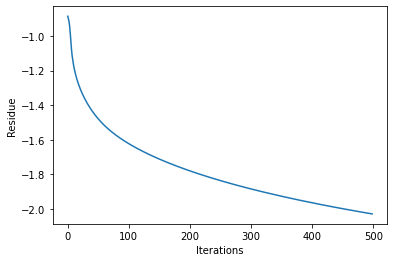

In [153]:
residues = []
for i in tqdm.tqdm(range(1000000)):
    W.grad = 2*K@(K@W - Id)@evolved_K
    if i > 1 and i%2000 == 0:
        model = -2*torch.trace(K@W@evolved_K) + torch.trace(torch.transpose(W, 0, 1)@K@K@W@evolved_K) + torch.trace(evolved_K)
        residues.append(model.item())
    optimizer.step()
residues = np.array(residues)
plt.plot(np.log(residues))
plt.xlabel('Iterations')
plt.ylabel('Residue')

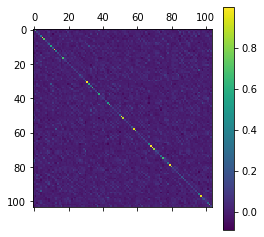

In [154]:
plt.matshow((K@W).cpu().detach().numpy())
plt.colorbar()

In [155]:
torch.linalg.cond(K)

tensor(5111.4688, device='cuda:0')